In [66]:
import tensorflow as tf
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [67]:
from deepface import DeepFace
import pandas as pd
from pandas import plotting
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # for progress bar
import json

from core import * # please take a look at this file. In it we kept everything shared between notebooks, hence 'core'

In [68]:
verification_cache = {model.value: { gbu.value : {} for gbu in GBU } for model in FVM}
verification_cache

{'VGG-Face': {'Good': {}, 'Bad': {}, 'Ugly': {}},
 'Facenet': {'Good': {}, 'Bad': {}, 'Ugly': {}},
 'Facenet512': {'Good': {}, 'Bad': {}, 'Ugly': {}},
 'OpenFace': {'Good': {}, 'Bad': {}, 'Ugly': {}},
 'DeepFace': {'Good': {}, 'Bad': {}, 'Ugly': {}},
 'DeepID': {'Good': {}, 'Bad': {}, 'Ugly': {}}}

In [70]:
def get_verification_result(comparison_key:str, gbu_name:str, model_name:str, img1_path:str, img2_path:str):
    if comparison_key in verification_cache[model_name][gbu_name]:
        return verification_cache[model_name][gbu_name][comparison_key]
    else:
        result = DeepFace.verify(img1_path = img1_path,img2_path = img2_path,model_name = model_name,
                                detector_backend = 'mtcnn', enforce_detection=False)
        verification_cache[model_name][gbu_name][comparison_key]=result
        return result

In [73]:
def verify_faces( model_type:FVM = FVM.vgg , gbu_type:GBU = GBU.good , limit:int=1100): # limit for faster testing
    
    genuine = []
    imposter = []
    
    query_path, target_path = get_query_target_paths(gbu_type)
    query_images = get_images_from_path(query_path)
    target_images = get_images_from_path(target_path)
    
    imposter_count=0
    genuine_count=0
    FAR_constant=0
    FRR_constant=0
    verification_runs=0 # we did this instead of using len() cz it's less expensive + we're using limit
    
    print(f"Verifying faces with {model_type.value} and {gbu_type.value}...")
    initial_time = datetime.now()
    
    for query_img in tqdm(query_images[:limit]): 
        query_person_id = int(query_img[:5])
        for target_img in target_images[:limit]:
            target_person_id = int(target_img[:5])
            
            comparison_key = tuple(sorted([target_person_id, query_person_id]))
            result = get_verification_result(comparison_key, gbu_type.value ,model_name = model_type.value ,
                    img1_path = query_path + query_img,img2_path = target_path + target_img,) 
            
            verification_runs += 1
           
            
            is_truly_the_same_person = target_person_id == query_person_id
            is_verified = result['verified']
            
            if(not is_truly_the_same_person and is_verified ): FAR_constant+=1
            if(is_truly_the_same_person and not is_verified ): FRR_constant+=1
            
            if is_verified:
                genuine_count+=1
                genuine.append(result)
            else:
                imposter_count+=1
                imposter.append(result)
    
    FAR = FAR_constant / imposter_count
    FRR = FRR_constant / genuine_count
    verification_rate = genuine_count / verification_runs
        
    end_time = datetime.now()
    delta_time = end_time-initial_time
    print(delta_time)
    return genuine, imposter, FAR, FRR, verification_rate


gen, imp, FAR, FRR, ver_rate = verify_faces(limit=50)

Verifying faces with VGG-Face and Good...


  0%|          | 0/50 [00:00<?, ?it/s]

0:01:52.510694


In [74]:
verification_cache

{'VGG-Face': {'Good': {(2463, 2463): {'verified': True,
    'distance': 0.226244913807363,
    'threshold': 0.4,
    'model': 'VGG-Face',
    'detector_backend': 'mtcnn',
    'similarity_metric': 'cosine'},
   (2463, 4202): {'verified': False,
    'distance': 0.5277763069383867,
    'threshold': 0.4,
    'model': 'VGG-Face',
    'detector_backend': 'mtcnn',
    'similarity_metric': 'cosine'},
   (2463, 4203): {'verified': False,
    'distance': 0.583499399762712,
    'threshold': 0.4,
    'model': 'VGG-Face',
    'detector_backend': 'mtcnn',
    'similarity_metric': 'cosine'},
   (2463, 4221): {'verified': False,
    'distance': 0.44963741368228527,
    'threshold': 0.4,
    'model': 'VGG-Face',
    'detector_backend': 'mtcnn',
    'similarity_metric': 'cosine'},
   (2463, 4225): {'verified': True,
    'distance': 0.36004793267301916,
    'threshold': 0.4,
    'model': 'VGG-Face',
    'detector_backend': 'mtcnn',
    'similarity_metric': 'cosine'},
   (2463, 4233): {'verified': True,
 

In [76]:
# when we run it again, it finishes in no time since the results are cached to memory
verify_faces(limit=50)

Verifying faces with VGG-Face and Good...


  0%|          | 0/50 [00:00<?, ?it/s]

0:00:00.022939


([{'verified': True,
   'distance': 0.226244913807363,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosine'},
  {'verified': True,
   'distance': 0.226244913807363,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosine'},
  {'verified': True,
   'distance': 0.226244913807363,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosine'},
  {'verified': True,
   'distance': 0.226244913807363,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosine'},
  {'verified': True,
   'distance': 0.36004793267301916,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosine'},
  {'verified': True,
   'distance': 0.36004793267301916,
   'threshold': 0.4,
   'model': 'VGG-Face',
   'detector_backend': 'mtcnn',
   'similarity_metric': 'cosi

In [77]:
def plot_imposter_distribution(genuine_list, imposter_list, model:FVM , gbu:GBU ):
    fig, ax = plt.subplots()
    pd.DataFrame(genuine_list, columns = ['distance'])['distance'].plot.kde(ax=ax, title=f"{model.value} + {gbu.value}")
    pd.DataFrame(imposter_list, columns = ['distance'])['distance'].plot.kde(ax=ax, title=f"{model.value} + {gbu.value}",
                                                                                                        linestyle="-.")
    ax.legend(["genuine", "imposter"])
    ax.set_xlabel("Probability")

Verifying faces with VGG-Face and Good...


  0%|          | 0/100 [00:00<?, ?it/s]

0:04:39.850785
Verifying faces with VGG-Face and Bad...


  0%|          | 0/100 [00:00<?, ?it/s]

0:06:39.718902
Verifying faces with VGG-Face and Ugly...


  0%|          | 0/100 [00:00<?, ?it/s]

0:06:35.569145
Verifying faces with Facenet and Good...


  0%|          | 0/100 [00:00<?, ?it/s]

0:05:51.995132
Verifying faces with Facenet and Bad...


  0%|          | 0/100 [00:00<?, ?it/s]

0:05:58.588261
Verifying faces with Facenet and Ugly...


  0%|          | 0/100 [00:00<?, ?it/s]

0:05:47.218434
Verifying faces with Facenet512 and Good...


  0%|          | 0/100 [00:00<?, ?it/s]

0:06:10.927943
Verifying faces with Facenet512 and Bad...


  0%|          | 0/100 [00:00<?, ?it/s]

0:06:02.777600
Verifying faces with Facenet512 and Ugly...


  0%|          | 0/100 [00:00<?, ?it/s]

0:05:32.654494
Verifying faces with OpenFace and Good...


  0%|          | 0/100 [00:00<?, ?it/s]

0:05:01.767825
Verifying faces with OpenFace and Bad...


  0%|          | 0/100 [00:00<?, ?it/s]

0:05:02.199473
Verifying faces with OpenFace and Ugly...


  0%|          | 0/100 [00:00<?, ?it/s]

0:04:59.014283
Verifying faces with DeepFace and Good...


  0%|          | 0/100 [00:00<?, ?it/s]

0:06:18.553692
Verifying faces with DeepFace and Bad...


  0%|          | 0/100 [00:00<?, ?it/s]

0:05:54.596522
Verifying faces with DeepFace and Ugly...


  0%|          | 0/100 [00:00<?, ?it/s]

0:05:48.540515
Verifying faces with DeepID and Good...


  0%|          | 0/100 [00:00<?, ?it/s]

0:04:38.739370
Verifying faces with DeepID and Bad...


  0%|          | 0/100 [00:00<?, ?it/s]

0:04:44.931924
Verifying faces with DeepID and Ugly...


  0%|          | 0/100 [00:00<?, ?it/s]

0:04:41.485307


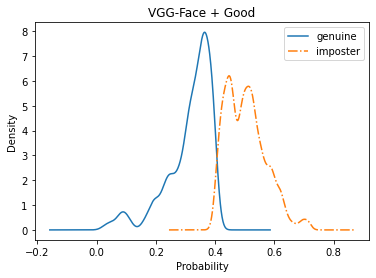

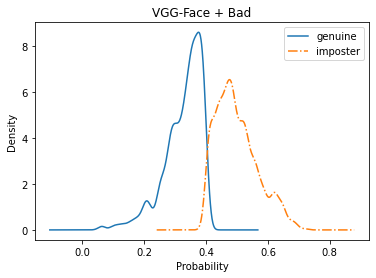

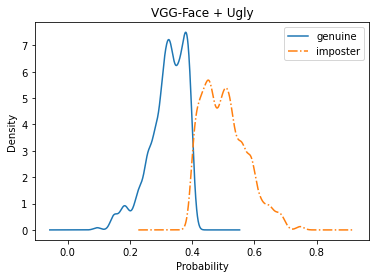

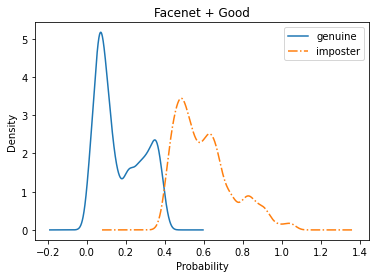

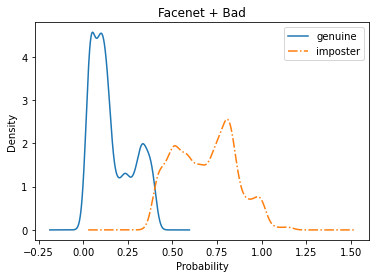

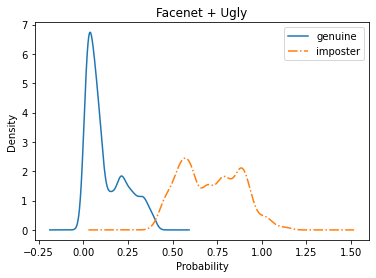

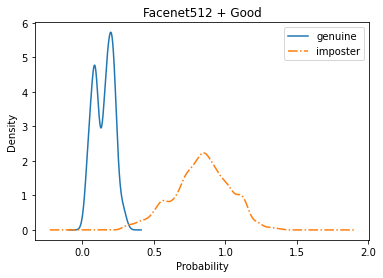

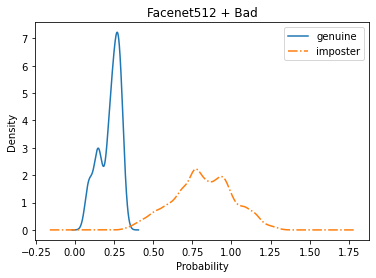

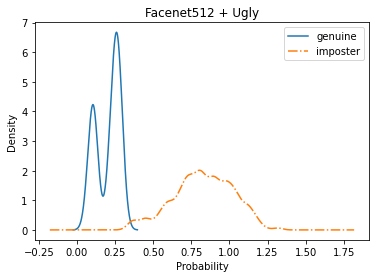

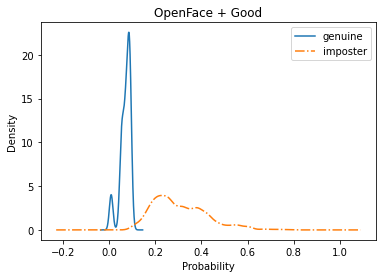

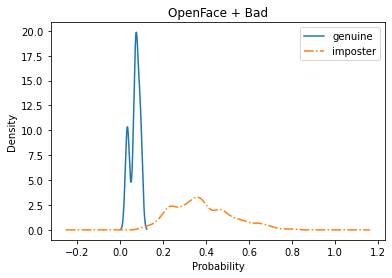

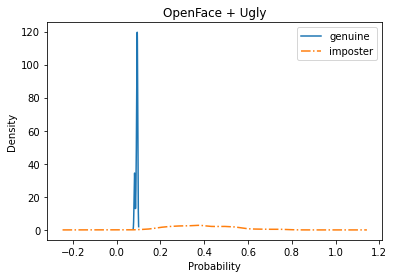

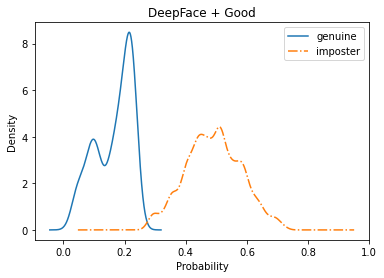

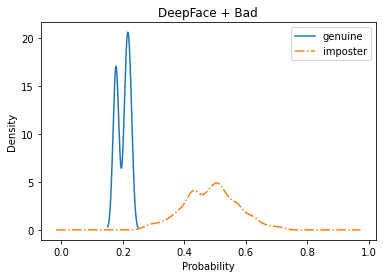

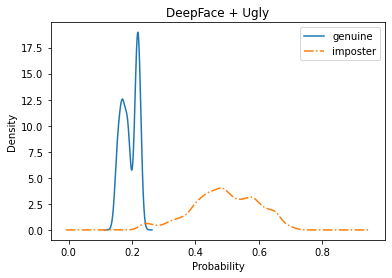

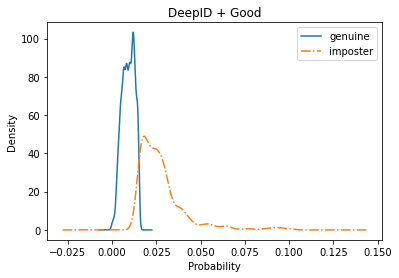

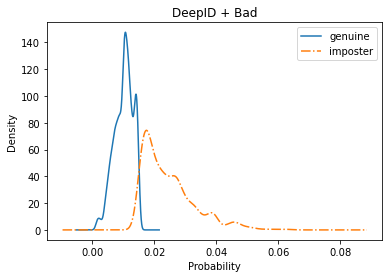

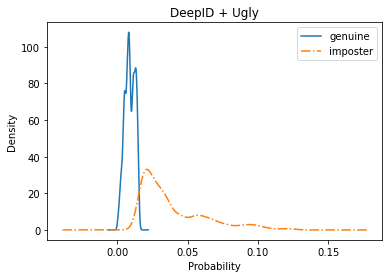

In [78]:
for face_veri_model in FVM:
    for gbu in GBU :
        genuine, imposter, FAR, FRR, ver_rate = verify_faces(face_veri_model, gbu, limit=100)
        plot_imposter_distribution(genuine, imposter, face_veri_model, gbu)